# Task 01: Prediction for time of using SCC - Regression

METADATA - SUPERCOMP INFORMATION
--------------------------------

Id - index
UID - user id                                                               [unused]  
GID - group id                                                              [unused]  
Area - subject area (defined by group)                                      [categorical -> OK]   
JobName - task name specified by the user                                   [categorical -> OK]  
Partition - the cluster on which the task was launched                      [categorical -> OK]  
ReqNodes - requested number of nodes                                        [numerical]  
ReqCPUS - requested number of processors                                    [numerical]  
Timelimit - user estimate of task completion time                           [encoding time -> OK]  
Submit - date when the task was uploaded to the system                      [encoding date -> OK]  
Start - the date when the task was launched for execution by the scheduler  [encoding date -> OK]  
Priority - task priority                                                    [numerical -> OK]  
Elapsed - actual task execution time (target variable Y)                    [encoding time -> OK]  
State - information about how the task completed (successfully, was canceled, etc.)   [categorical -> OK]  
ExitCode - code generated after some scc task                               [categorical -> OK]  

### Step 1: Preprocessing

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("datasets/train_w_areas_st_till_june.csv")
data.head()

,Unnamed: 0,UID,GID,Area,JobName,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Start,Elapsed,Priority,State,ExitCode
0,0,1420,88068,astrophys,Smilei0,tornado,70,1960,10-00:00:00,2021-08-11T16:53:04,2021-09-17T09:46:21,1-11:27:29,1,CANCELLED by 50260,0:0
1,1,52951,3414,phys,v149_td,tornado,2,56,14-00:00:00,2021-08-18T10:38:10,2021-08-18T10:46:12,14-00:00:38,1,TIMEOUT,0:0
2,2,24801,97723,mech,fluent,tornado,6,168,14-00:00:00,2021-08-18T14:50:05,2021-08-18T14:50:05,13-21:05:40,1,CANCELLED by 50341,0:0
3,3,24801,97723,mech,fluent,tornado,6,168,14-00:00:00,2021-08-18T14:52:31,2021-08-18T14:52:32,13-21:04:39,1,CANCELLED by 50341,0:0
4,4,70802,33028,energ,dcss.slurm,tornado-k40,1,1,14-00:00:00,2021-08-19T15:33:49,2021-08-19T15:33:50,14-00:00:04,1,TIMEOUT,0:0


In [3]:
# check important information
print("#total of samples = ", len(data))
print("#users = ", len(data["UID"].unique()))

#total of samples =  1290729
#users =  245


Filter missing values

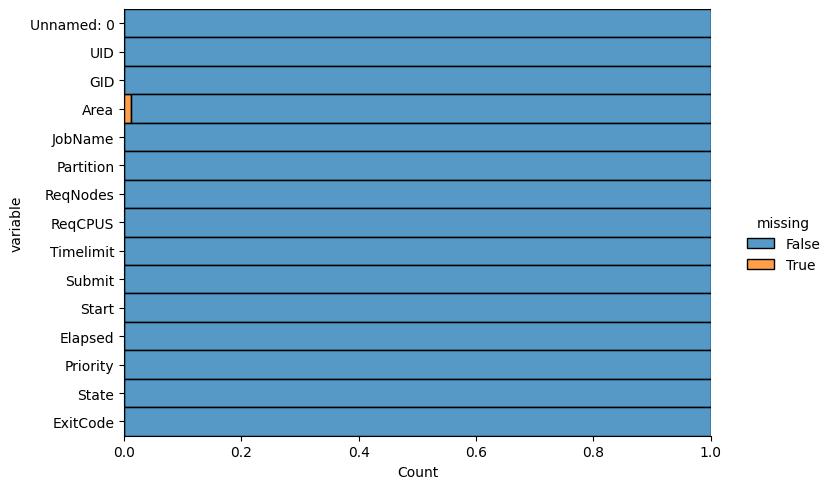

In [4]:
# check missing data
sns.displot(
    data = data.isna().melt(value_name="missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 1.5
)

plt.show()

In [5]:
data = data.dropna()
print("#total samples without missing values = ", len(data))

#total samples without missing values =  1275902


In [6]:
# check information of dataset
print("Number of samples: ", len(data.index))
print("Columns = ", data.columns)
print("#Columns = ", len(data.columns))

Number of samples:  1275902
Columns =  Index(['Unnamed: 0', 'UID', 'GID', 'Area', 'JobName', 'Partition', 'ReqNodes',
       'ReqCPUS', 'Timelimit', 'Submit', 'Start', 'Elapsed', 'Priority',
       'State', 'ExitCode'],
      dtype='object')
#Columns =  15


Encode State

In [7]:
def replace_cancelled_states(status):
    if "CANCELLED" in status:
        return "CANCELLED"
    return status

In [8]:
def encoding_states(data, column):
    data[column] = data[column].apply(lambda x: replace_cancelled_states(x))
    return data

In [9]:
data = encoding_states(data, "State")

Build metadata dictionary

In [10]:
import calendar 

def build_metadata(data):
    # define spend time metadata
    st_cols = ["Timelimit", "Elapsed"]
    st_metadata = [f"Log{col}Sec" for col in st_cols]

    # define time metadata
    time_cols = ["Submit", "Start"]
    t_instances = {
        "Year": list(np.arange(2020, 2025, 1)),
        "Month": list(calendar.month_name)[1:],
        "DayWeek": list(calendar.day_name),
    }
    time_metadata = [f"{tcol}{key} {value}" for tcol in time_cols for key, values in t_instances.items() for value in values]    

    # define categorical instances
    cat_cols = ["Area", "Partition", "State"]
    cat_instances = {        
        "Area": data["Area"].unique().tolist(),
        "Partition": data["Partition"].unique().tolist(),
        "State": data["State"].unique().tolist()
    }
    categorical_metadata = [f"{key} {value}" for key, values in cat_instances.items() for value in values]

    # define metadata from original dataset
    original_metadata = data.columns[1:].tolist()

    # filtered columns
    filtered_cols = ["UID", "GID", "JobName", "ExitCode"] + st_cols + time_cols + cat_cols

    # get metadata
    dict_metadata = {        
        **cat_instances,
        "scc_metadata": [item for item in original_metadata if item not in filtered_cols] + 
                            st_metadata + ["LogTimeWaitting"] + time_metadata + categorical_metadata
    }

    return dict_metadata

In [11]:
# store dictionary of metadata
import json

def save_dictionary(dict, file_path):
    with open(file_path, "w") as file:
        json.dump(dict, file)

In [12]:
# load dictionary
def load_dictionary(file_path):
    with open(file_path, "r") as file:
        return json.load(file)

In [13]:
dict_metadata = build_metadata(data)

In [14]:
save_dictionary(dict_metadata, "metadata/scc_metadata.json")

In [15]:
dict_metadata = load_dictionary("metadata/scc_metadata.json")

In [16]:
num_features = len(dict_metadata["scc_metadata"])
print(f"#features = {num_features}")

#features = 75


Encode transcurred time (D-HH:MM:SS)

In [17]:
# function to convert transcurred time to logaritmic scale of seconds
def time_conversion(time_data):
    # extract time units
    if "-" in time_data:
        days, timer = time_data.split("-")
    else:
        days = 0
        timer = time_data 
    
    days = int(days)
    hours, min, sec = map(int, timer.split(":"))

    # calculate total seconds
    total_sec = days*24*60*60 + hours*60*60 + min*60 + sec
    
    return total_sec

In [18]:
# function to encode transcurred time for entire column
def encoding_time(data, name_col):
    data["Log"+name_col+"Sec"] = data[name_col].apply(time_conversion)
    data["Log"+name_col+"Sec"] = np.log10(1 + data["Log"+name_col+"Sec"])
    
    return data

Encode time difference between Task submitted and started

In [19]:
# function to calculate difference between 2 dates
from datetime import datetime

def difference_dates(date1, date2):
    dformat = "%Y-%m-%dT%H:%M:%S"
    date1 = datetime.strptime(date1, dformat)
    date2 = datetime.strptime(date2, dformat)
    tdiff = date2 - date1

    return tdiff.total_seconds()

In [20]:
# function to calculate wait time between submission and start task
def encode_twatting(data, col1, col2):
    data["LogTimeWaitting"] = data.apply(lambda row: difference_dates(row[col1], row[col2]), axis = 1)
    data["LogTimeWaitting"] = np.log10(1 + data["LogTimeWaitting"])
    
    return data

Encode dates

In [21]:
import calendar

def encoding_date(data, name_col):
    #categorical variants of values
    year_names = list(np.arange(2020, 2025, 1))
    year_variants = [f"{name_col}Year {i}" for i in year_names]
    month_names = list(calendar.month_name)
    month_variants = [f"{name_col}Month {j}" for j in month_names if j!='']
    dayw_names = list(calendar.day_name)
    dayw_variants = [f"{name_col}DayWeek {k}" for k in dayw_names]
    # temporal dataframe
    tmp_cols = year_variants + month_variants + dayw_variants
    tmp_frame = pd.DataFrame(np.zeros((len(data), len(tmp_cols))), columns = tmp_cols)
    tmp_frame.index = data.index
    # generate datetime
    dates_mod = pd.to_datetime(data[name_col])
    dates_mod.index = data.index
    
    for i, date_val in dates_mod.items():
        tmp_frame.loc[i, f"{name_col}Year {date_val.year}"] = 1
        tmp_frame.loc[i, f"{name_col}Month {calendar.month_name[date_val.month]}"] = 1
        tmp_frame.loc[i, f"{name_col}DayWeek {calendar.day_name[date_val.day_of_week]}"] = 1

    # concatenate data-frames
    data = pd.concat([data, tmp_frame], axis = 1, ignore_index = False)

    return data

Encode categorical data

In [22]:
# one-hot encoder for categorical variables 
def encoding_category(data, category):
    col_instances = [f"{category} {i}" for i in dict_metadata[category]]
    tmp_df = pd.DataFrame(np.zeros((len(data), len(col_instances))), columns = col_instances)
    tmp_df.index = data.index

    for i, cat_val in data[category].items():
        tmp_df.loc[i, f"{category} {cat_val}"] = 1
    # concatenate data-frames
    data = pd.concat([data, tmp_df], axis = 1, ignore_index = False)

    return data

Final pipeline for data preprocessing

In [23]:
def preprocessing_pipeline(data):
    # encode states
    data = encoding_states(data, "State")
    # encode the Time limit
    data = encoding_time(data, "Timelimit")
    # encode the Time elapsed
    data = encoding_time(data, "Elapsed")
    # encode the Time of waitting
    data = encode_twatting(data, "Submit", "Start")
    # encode the Submit dates
    data = encoding_date(data, "Submit")
    # encode the Start dates
    data = encoding_date(data, "Start")
    
    # one-hot encoding for categorical variables    
    list_cats = [key for key in dict_metadata.keys() if key!="scc_metadata"]

    for category in list_cats:
        data = encoding_category(data, category)
    
    # drop the original preprocessed columns
    data = data.drop(columns = [c for c in data.columns.tolist() if c not in dict_metadata["scc_metadata"]])

    return data

In [24]:
import time
start_tpreproc = time.time()

In [25]:
# preprocess entire data
data = preprocessing_pipeline(data)

In [26]:
end_tpreproc = time.time()
print(f"Preprocessing time: {end_tpreproc - start_tpreproc} seconds")

Preprocessing time: 1709.103511095047 seconds


### Step 2: Statistical Analysis

In [27]:
import seaborn as sns
# function to plot distribution under 
def plot_time_distribution(data, column):    
    sns.histplot(data[column], color = "gray")
    plt.xlabel("Time (in log10 scale)")
    plt.ylabel("Frequencies")
    plt.title("Histogram distribution for " + column)    
    plt.show()

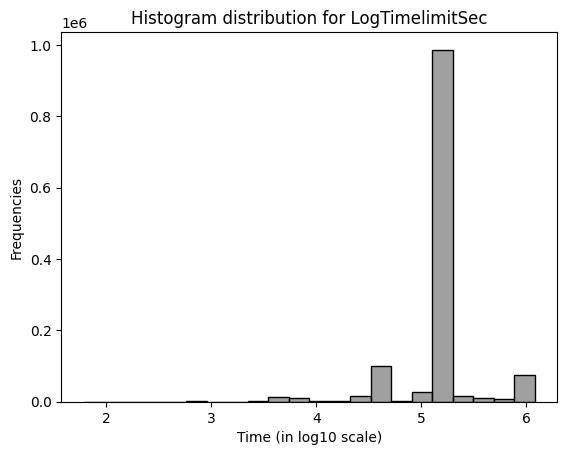

In [28]:
plot_time_distribution(data, "LogTimelimitSec")

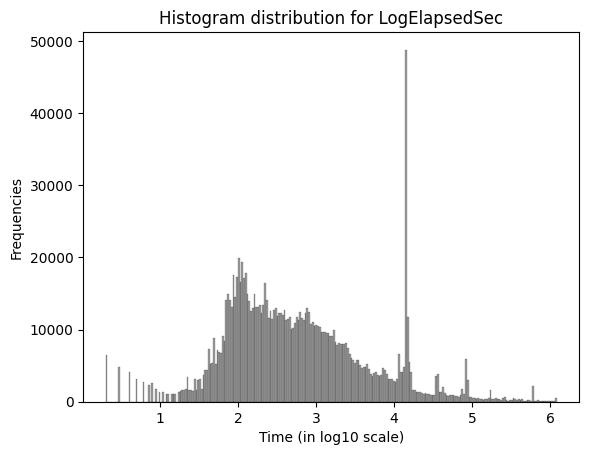

In [29]:
plot_time_distribution(data, "LogElapsedSec")

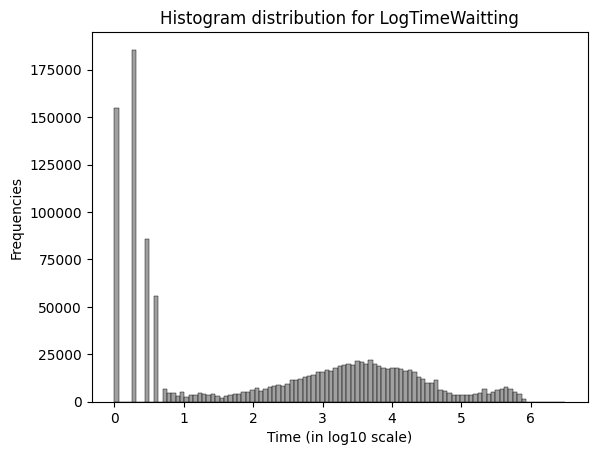

In [31]:
plot_time_distribution(data, "LogTimeWaitting")

In [32]:
# information to graph boxplot
def plot_time_boxplot(data, col1, col2, col3):
    fig, axs = plt.subplots(1, 3, figsize = (12, 4))
    sns.boxplot(data[col1], ax = axs[0])
    axs[0].set_title("Box Plot for Time Limit (in log10 scale)")
    sns.boxplot(data[col2], ax = axs[1])    
    axs[1].set_title("Box plot for Time Elapsed (in log10 scale)")
    sns.boxplot(data[col3], ax = axs[2])
    axs[2].set_title("Box plot for Time Waitting (in log10 scale)")    
    plt.tight_layout()
    plt.show()

In [33]:
# check statistics for original times
data[["LogTimelimitSec", "LogElapsedSec", "LogTimeWaitting"]].describe()

,LogTimelimitSec,LogElapsedSec,LogTimeWaitting
count,1.275902e+06,1.275902e+06,1.275902e+06
mean,5.185922e+00,2.749971e+00,2.252883e+00
std,3.872218e-01,9.260652e-01,1.787600e+00
min,1.785330e+00,3.010300e-01,0.000000e+00
25%,5.237546e+00,2.075547e+00,3.010300e-01
50%,5.237546e+00,2.617000e+00,2.565848e+00
75%,5.237546e+00,3.302980e+00,3.749659e+00
max,6.082642e+00,6.082656e+00,6.501223e+00


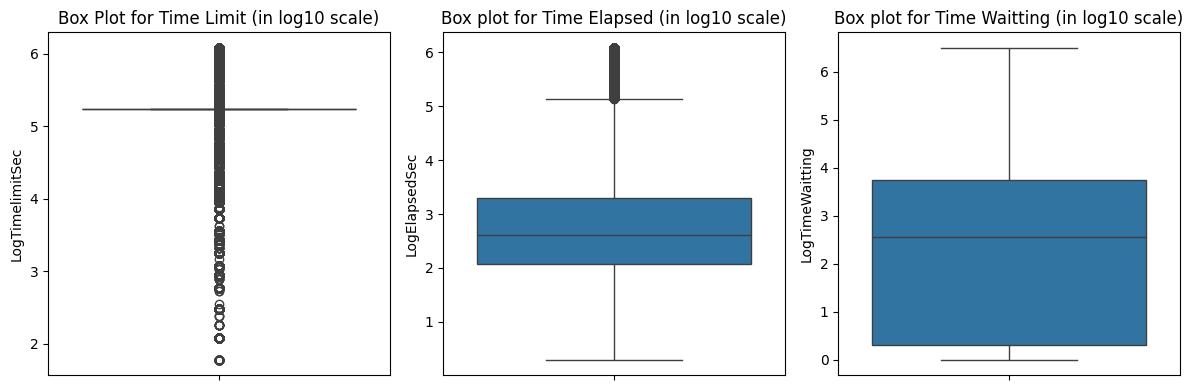

In [34]:
plot_time_boxplot(data, "LogTimelimitSec", "LogElapsedSec", "LogTimeWaitting")

In [35]:
data.head()

,ReqNodes,ReqCPUS,Priority,LogTimelimitSec,LogElapsedSec,LogTimeWaitting,SubmitYear 2020,SubmitYear 2021,SubmitYear 2022,SubmitYear 2023,...,Partition tornado-k40,Partition g2,Partition cascade,Partition nv,State CANCELLED,State TIMEOUT,State COMPLETED,State FAILED,State NODE_FAIL,State OUT_OF_MEMORY
0,70,1960,1,5.936514,5.106021,6.501223,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,56,1,6.082642,6.082656,2.683947,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,6,168,1,6.082642,6.078870,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,6,168,1,6.082642,6.078848,0.301030,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1,6.082642,6.082644,0.301030,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Categorical Features - Area

In [36]:
def count_categories(data, col):
    categ_instances = [categ for categ in data.columns if categ.startswith(col)]
    categ_counts = data[categ_instances].sum()

    return categ_counts

In [37]:
def plot_count_categories(col, results):
    sns.barplot(x = results.values.tolist(), y = results.index.tolist(), orient = "y")
    plt.title("Statistical analysis by " + col)
    plt.show()

In [38]:
count_areas = count_categories(data, "Area")
print(count_areas)

Area astrophys      2338.0
Area phys          54034.0
Area mech          10800.0
Area energ          8985.0
Area mach          34500.0
Area radiophys     81953.0
Area biophys       21923.0
Area geophys      999420.0
Area bioinf        41840.0
Area it            20109.0
dtype: float64


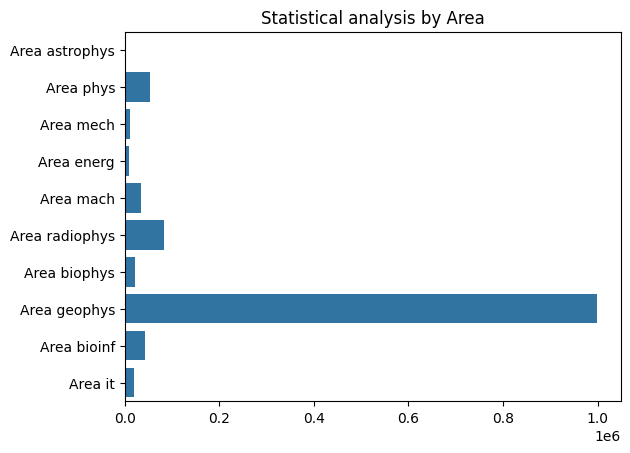

In [39]:
plot_count_categories("Area", count_areas)

Outliers detection using Z-score method

In [40]:
from scipy import stats

def outliers_detection(data, col):
    z_score = stats.zscore(data[col])
    z_threshold = 3
    outliers = data[z_score.abs() > z_threshold]
    
    return outliers

In [41]:
lst_outliers = outliers_detection(data, "LogElapsedSec")

In [42]:
print(f"#samples outlier to distribution = {len(lst_outliers)}")
print(f"%outliers = {round(100* len(lst_outliers)/len(data), 2)} %")

#samples outlier to distribution = 6664
%outliers = 0.52 %


Split Data

In [43]:
# split independent (X) and dependent variable (Y)
x = data.drop(columns = ["LogElapsedSec"])
y = data["LogElapsedSec"]

In [44]:
# split train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [45]:
# check number of samples
print("#train samples = ", len(x_train))
print("#test samples = ", len(x_test))

#train samples =  1020721
#test samples =  255181


Functions to save and load models

In [46]:
import pickle

# function to save model
def save_model(filename, model):
    with open(filename, "wb") as file:
        pickle.dump(model, file)

In [47]:
# function to load model
def load_model(filename):
    with open(filename, "rb") as file:
        return pickle.load(file)

### Training models  
Benchmark for models:  
- XGBoost Regressor  
- LightGBM Regressor
- Support Vector Regressor (SVR) + RBF  
- Multilayer Perceptron (MLP)

In [48]:
from sklearn.model_selection import GridSearchCV

#### XGBoost Regressor

Training with XGBoost Regressor + Hyperparameter Tuning

In [49]:
import xgboost as xgb

xgb_params = {          
    "max_depth": [16, 32, 48, 64],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.8, 0.9],     
    "tree_method": ["hist"],
    "objective": ["reg:squarederror"]
}

In [50]:
# function for training
def XGBModel(x_train, y_train, params):
    # define the model    
    model = xgb.XGBRegressor()
    
    # hyperparameter optimization
    grid_search = GridSearchCV(estimator = model,
                               param_grid = params,
                               scoring = "neg_mean_squared_error",
                               cv = 5,
                               n_jobs = -1
                            )
    grid_search.fit(x_train, y_train)
    
    # get best model
    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    
    return best_model

In [51]:
start_ttrain = time.time()

In [52]:
xgb_model = XGBModel(x_train, y_train, xgb_params)

/home/iknthsait/holtech/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 32, 'objective': 'reg:squarederror', 'subsample': 0.7, 'tree_method': 'hist'}


In [53]:
end_ttrain = time.time()
print(f"Time of training: {end_ttrain - start_ttrain} seconds")

Time of training: 2088.8206140995026 seconds


In [54]:
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
# save xgb model
save_model("models/xgb_scc_mod_v1.pkl", xgb_model)

Inference with XGBoost Regressor

In [57]:
# recover the model
rec_xgb = load_model("models/xgb_scc_mod_v1.pkl")

In [58]:
# function to evaluate
from sklearn.metrics import mean_squared_error, r2_score

def eval_model_perform(model, x, y):    
    y_pred = model.predict(x)
    rmse_val = np.sqrt(mean_squared_error(y, y_pred))
    r2_val = r2_score(y, y_pred)

    return rmse_val, r2_val

In [59]:
# metrics for train set
rmse_xgb_train, r2_xgb_train = eval_model_perform(rec_xgb, x_train, y_train)
print(f"R-MSE train score: {rmse_xgb_train:.3f}")
print(f"R^2 train score: {r2_xgb_train:.3f}")

R-MSE train score: 0.356
R^2 train score: 0.852


In [60]:
# r2-score for test set
rmse_xgb_test, r2_xgb_test = eval_model_perform(rec_xgb, x_test, y_test)
print(f"R-MSE train score: {rmse_xgb_test:.3f}")
print(f"R^2 train score: {r2_xgb_test:.3f}")

R-MSE train score: 0.434
R^2 train score: 0.781


******

#### LightGBM Regressor

Training with LightGBM Regressor + Hyperparameter Tuning

In [61]:
!pip show lightgbm

Name: lightgbm
Version: 2.2.3
Summary: LightGBM Python Package
Home-page: https://github.com/Microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (Microsoft)
Location: /home/iknthsait/holtech/.local/lib/python3.10/site-packages
Requires: numpy, scikit-learn, scipy
Required-by: 


In [66]:
# import packages
import lightgbm as lgbm

# define grid hyperparameters
lgbm_params = {    
    "num_leaves": [256, 512, 1024, 2048],
    "max_depth": [20, 30, 40, 50],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 0.9],
    "subsample_freq": [10] # re-sample without replacement every 10 iterations
                         # and extract bagging_fraction% of training data
}

In [67]:
# define the LightGBM regressor
def LightGBModel(x_train, y_train, params):
    lgbm_model = lgbm.LGBMRegressor()
    
    # hyperparameter optimization
    grid_lgbm = GridSearchCV(estimator = lgbm_model,  # regressor model
                         param_grid = params,  # dict of hyperparameters
                         cv = 5,   # 5-fold cross-validation
                         scoring = "r2",
                         verbose = False,
                         n_jobs = -1
                    )
    # fit the model
    grid_lgbm.fit(x_train, y_train)
    
    # take best model
    best_model = grid_lgbm.best_estimator_
    print(grid_lgbm.best_params_)

    return best_model

In [68]:
start_ttrain2 = time.time()

In [69]:
# take the best model
lgbm_model = LightGBModel(x_train, y_train, lgbm_params)

{'learning_rate': 0.1, 'max_depth': 50, 'num_leaves': 2048, 'subsample': 0.9, 'subsample_freq': 10}


In [70]:
end_ttrain2 = time.time()
print(f"Time of training: {end_ttrain2 - start_ttrain2}")

Time of training: 972.7517931461334


In [71]:
lgbm_model

LGBMRegressor(max_depth=50, num_leaves=2048, subsample=0.9, subsample_freq=10)

In [72]:
# save best xgboost model
save_model("models/lgbm_scc_mod_v1.pkl", lgbm_model)

Inference with LightGBM

In [73]:
# recover the model
rec_lgbm = load_model("models/lgbm_scc_mod_v1.pkl")

In [74]:
# metrics for train set
rmse_lgbm_train, r2_lgbm_train = eval_model_perform(rec_lgbm, x_train, y_train)
print(f"R-MSE train score: {rmse_lgbm_train:.3f}")
print(f"R^2 train score: {r2_lgbm_train:.3f}")

R-MSE train score: 0.400
R^2 train score: 0.813


In [75]:
# metrics for test set
rmse_lgbm_test, r2_lgbm_test = eval_model_perform(rec_lgbm, x_test, y_test)
print(f"R-MSE test score: {rmse_lgbm_test:.3f}")
print(f"R^2 test score: {r2_lgbm_test:.3f}")

R-MSE test score: 0.435
R^2 test score: 0.780


*******

#### Support Vector Regressor (SVR) + RBF

Training with SVR + Hyperparameter Tuning

In [62]:
from sklearn import svm

# define grid hyperparameters
svr_params = {
    "C": [0.1, 0.5, 1, 10, 100],
    "epsilon": [0.01, 0.1, 1],
    "gamma": [5e-3, 0.01, 0.1, 1]
}

In [63]:
# define the SVR
def SVRModel(x_train, y_train, params):
    svr_model = svm.SVR(kernel = "rbf")

    # hyperparameter optimization
    grid_svr = GridSearchCV(estimator = svr_model,  # regressor model
                         param_grid = params,  # dict of hyperparameters
                         cv = 5,   # 5-fold cross-validation
                         scoring = "neg_mean_squared_error",
                         verbose = False,
                         n_jobs = -1
                    )
    # fit model
    grid_svr.fit(x_train, y_train)

    # take best model
    best_model = grid_svr.best_estimator_
    print(grid_svr.best_params_)

    return best_model

In [64]:
start_ttrain3 = time.time()

In [65]:
# take the best model
svr_model = SVRModel(x_train, y_train, svr_params)

KeyboardInterrupt: 

In [ ]:
end_ttrain3 = time.time()
print(f"Time of training: {end_ttrain3 - start_ttrain3}")

In [ ]:
svr_model

In [ ]:
# save best svr model
save_model("models/svr_scc_mod_v1.pkl", svr_model)

Inference with SVR

In [ ]:
# recover the model
rec_svr = load_model("models/svr_scc_mod_v1.pkl")

In [ ]:
# metrics for train set
rmse_svr_train, r2_svr_train = eval_model_perform(rec_svr, x_train, y_train)
print(f"R-MSE train score: {rmse_svr_train:.3f}")
print(f"R^2 train score: {r2_svr_train:.3f}")

In [ ]:
# metrics for test set
rmse_svr_test, r2_svr_test = eval_model_perform(rec_svr, x_test, y_test)
print(f"R-MSE test score: {rmse_svr_test:.3f}")
print(f"R^2 test score: {r2_svr_test:.3f}")